## Modeling
- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, LogisticRegression,Lasso, ElasticNet, ElasticNetCV
from sklearn import metrics
import sklearn as sklearn

In [22]:
train = pd.read_csv('datasets/train_clean.csv')

In [23]:
train.head()

,Unnamed: 0,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,0,60,RL,68.0,13517,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,3,2010,WD,130500
1,1,60,RL,43.0,11492,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,4,2009,WD,220000
2,2,20,RL,68.0,7922,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,1,2010,WD,109000
3,3,60,RL,73.0,9802,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,4,2010,WD,174000
4,4,50,RL,82.0,14235,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,3,2010,WD,138500


In [24]:
train.shape

(2044, 79)

In [25]:
train = train.drop(['Unnamed: 0'],axis=1)

In [26]:
test = pd.read_csv('datasets/test_clean.csv')
test.head()

,Id,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,None,None,None,0,4,2006,WD
1,2718,905108090,90,RL,0.0,9662,Pave,None,IR1,Lvl,...,0,0,0,None,None,None,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,None,IR1,Lvl,...,0,0,0,None,None,None,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,None,Reg,Lvl,...,0,0,0,None,None,None,0,7,2007,WD
4,625,535105100,20,RL,0.0,9500,Pave,None,IR1,Lvl,...,0,185,0,None,None,None,0,7,2009,WD


In [27]:
test.shape

(879, 79)

### Mean Baseline Model

Creating a baseline model from the mean of the sale price and a selected column

In [28]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

train_numeric = train.select_dtypes(include=numerics)
train_numeric.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,68.0,13517,6,8,1976,2005,289.0,533.0,0.0,...,0,44,0,0,0,0,0,3,2010,130500
1,60,43.0,11492,7,5,1996,1997,132.0,637.0,0.0,...,0,74,0,0,0,0,0,4,2009,220000
2,20,68.0,7922,5,7,1953,2007,0.0,731.0,0.0,...,0,52,0,0,0,0,0,1,2010,109000
3,60,73.0,9802,5,5,2006,2007,0.0,0.0,0.0,...,100,0,0,0,0,0,0,4,2010,174000
4,50,82.0,14235,6,8,1900,1993,0.0,0.0,0.0,...,0,59,0,0,0,0,0,3,2010,138500


In [29]:
corr = train_numeric.corr()
corr.sort_values(by='SalePrice',ascending=False)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
SalePrice,-0.088977,0.341900,0.306382,0.804580,-0.099436,0.572691,0.549464,0.511631,0.445993,0.015902,...,0.327514,0.336601,-0.135126,0.048647,0.134355,0.025756,-0.010531,0.029827,-0.015990,1.000000
OverallQual,0.033346,0.179431,0.101902,1.000000,-0.085905,0.603605,0.583286,0.424013,0.264997,-0.028966,...,0.251717,0.303198,-0.152301,0.032045,0.048613,-0.011021,-0.023359,0.015756,-0.013277,0.804580
GrLivArea,0.074535,0.311431,0.286220,0.571663,-0.112770,0.260213,0.322815,0.364151,0.156817,0.003991,...,0.265287,0.313050,-0.006034,0.026378,0.108443,0.067264,0.014297,0.052707,-0.014886,0.720801
TotalBsmtSF,-0.239152,0.290885,0.245867,0.548705,-0.164859,0.420290,0.312565,0.377608,0.489352,0.093630,...,0.214543,0.229479,-0.087577,0.064554,0.082501,-0.008632,-0.005423,0.006499,-0.004145,0.666530
GarageArea,-0.108428,0.324933,0.248299,0.562125,-0.138351,0.486515,0.397238,0.369812,0.312587,0.014343,...,0.240460,0.233501,-0.111094,0.044584,0.072539,0.019885,-0.015565,0.011415,-0.003683,0.655823
1stFlrSF,-0.254326,0.392141,0.335043,0.486536,-0.158332,0.332359,0.245997,0.365072,0.421654,0.105188,...,0.220797,0.211160,-0.042362,0.072311,0.098136,0.083391,-0.004189,0.028227,-0.005465,0.652754
GarageCars,-0.049197,0.288116,0.217714,0.589989,-0.169256,0.542090,0.440915,0.356115,0.265671,-0.001923,...,0.238505,0.212957,-0.138715,0.028450,0.053715,0.020611,-0.026544,0.019620,-0.010211,0.649374
YearBuilt,0.035682,0.100724,0.031834,0.603605,-0.371752,1.000000,0.629542,0.318687,0.277235,-0.021206,...,0.214496,0.206012,-0.378865,0.016042,-0.038196,-0.003939,-0.022266,-0.008654,-0.004081,0.572691
YearRemod/Add,0.043588,0.078374,0.046399,0.583286,0.041773,0.629542,1.000000,0.200812,0.162771,-0.057220,...,0.213424,0.261936,-0.238684,0.040467,-0.041491,-0.030730,-0.024895,0.010071,0.042509,0.549464
FullBath,0.142580,0.137843,0.119739,0.516928,-0.222550,0.481526,0.469896,0.232654,0.071552,-0.073949,...,0.174569,0.239149,-0.126037,0.028039,-0.014092,0.005993,-0.010293,0.048500,0.006810,0.536978


In [30]:
corr.sort_values(by='SalePrice',ascending=False).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Text(0, 0.5, 'Sale Price')

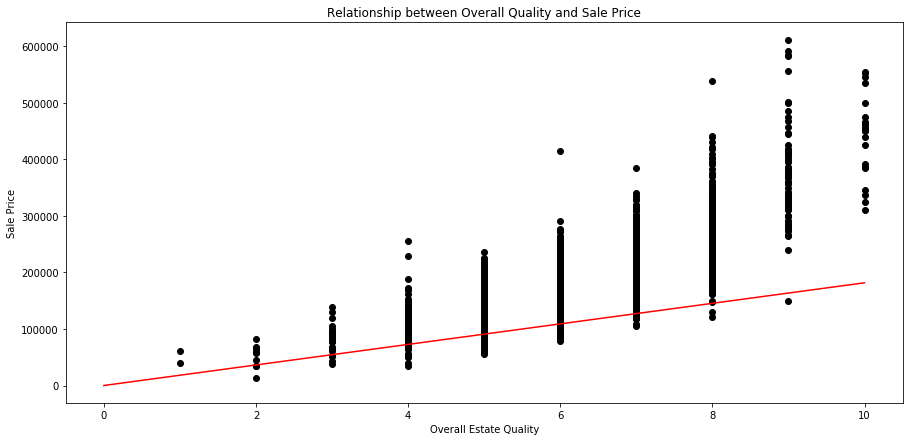

In [31]:
#ploting a baseline model for the top two with highest correlation to saleprice (OverallQual)
plt.figure(figsize=(15,7))

plt.scatter(train_numeric['OverallQual'], train_numeric['SalePrice'], color='black')

plt.plot((0, 10),(np.mean(train_numeric['OverallQual']), np.mean(train_numeric['SalePrice'])),color='red');
plt.title('Relationship between Overall Quality and Sale Price')
plt.xlabel('Overall Estate Quality')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

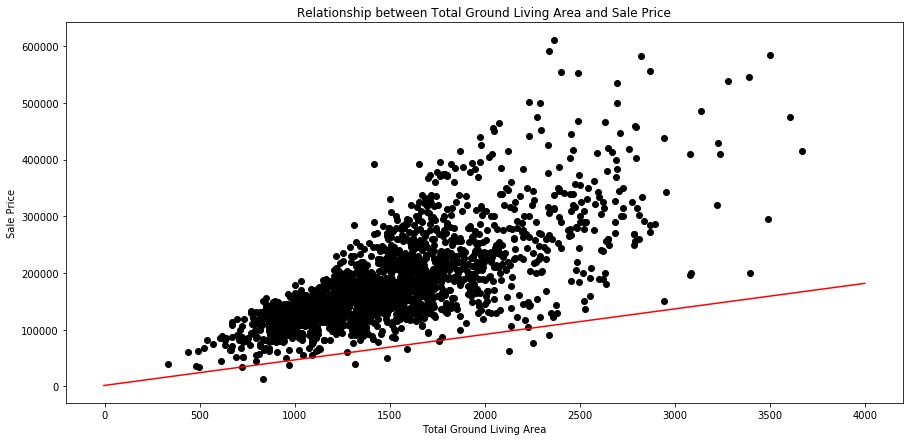

In [32]:
#ploting a baseline model for the top two with highest correlation to saleprice (GrLivArea)
plt.figure(figsize=(15,7))

plt.scatter(train_numeric['GrLivArea'], train_numeric['SalePrice'], color='black')

plt.plot((-5, 4000),(np.mean(train_numeric['GrLivArea']), np.mean(train_numeric['SalePrice'])),color='red');
plt.title('Relationship between Total Ground Living Area and Sale Price')
plt.xlabel('Total Ground Living Area')
plt.ylabel('Sale Price')

### Linear as a Baseline Model

After the mean baseline model I wanted to create a simple linear regression model to understand the data and correlation better to be able to use this for future model tuning reference.

In [33]:
#Select MLR with numeric variable that have >0.5 or more correlation with SalePrice
features = ['TotRmsAbvGrd','MasVnrArea','FullBath','YearRemod/Add','YearBuilt','GarageCars','GarageArea', 'TotalBsmtSF','GrLivArea','OverallQual']
X = train[features]
y = train['SalePrice']

In [34]:
lr = LinearRegression()
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
lr.score(X,y)

0.8380910579486031

In [36]:
cross_val_score(lr,X,y).mean()

0.8355751268151712

##### Testing the Linear Model

After the test and fit I will be inputing the test data test to generate a prediction and see how the model do.

In [37]:
predict = lr.predict(test[features])
predict

array([164117.11389371, 218128.47616669, 184701.99595601, 127115.36004183,
       191492.94022567,  92675.26047037, 116546.28133186, 154941.20732895,
       216653.84092095, 161198.86292039, 169117.20154771, 137810.47244995,
       170732.87162894, 276270.88967265, 173372.99411743, 112680.14834925,
       154183.98269853, 121225.86554583, 200913.06376691, 198172.44702379,
       135504.94266072, 120865.41663532, 213866.5104142 , 144945.88319897,
       210153.71376216, 110600.42113496, 131380.13385397, 132393.36513089,
       146117.98136118,  16231.6483306 , 111277.8802813 ,  99864.31912204,
       275855.86130601, 156444.34066651, 233083.31688121, 185767.41061984,
       130200.48922348,  56715.44156011,  89498.15419993, 212011.28062117,
       164362.66184913, 211304.2868929 , 165189.7119815 , 152112.1506566 ,
       229345.76960077, 108307.45207315, 228743.71883621, 106951.04833332,
       124359.13560631, 120684.5301636 , 106544.95502407, 206867.40045507,
       274442.94004202, 1

In [38]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':predict})
df_pred.head()

,Id,SalePrice
0,2658,164117.113894
1,2718,218128.476167
2,2414,184701.995956
3,1989,127115.360042
4,625,191492.940226


In [39]:
df_pred.to_csv('base_result.csv',index=False)

## Model Tuning

I will be creating prediction models and testing different features to see which would yield the best prediction result jusge by kaggle score. As I make prediction models there might be some cleaning of the data allow the way as well to help adjust and make sure that the features selected are the best possible.

### Model Automation

Since we will be creating many models, using similar instructions I have decided to create a fuction to help shorten the process of model generation when chaneging features input.

In [40]:
def modeling(features,train,test):
    # picking features and normalizing the data
    Xtrain = train[features]
    y = train['SalePrice']
    ss = StandardScaler()
    Xtrain_ss = ss.fit_transform(Xtrain)
    Xtest = test[features] #test set
    Xtest_ss = ss.transform(Xtest) #test set
    
    # training and optimized each model
    lr = LinearRegression()
    
    ridgecv = RidgeCV(alphas=np.linspace(0.1,10,100))
    ridgecv.fit(Xtrain_ss,y)
    ridge = Ridge(alpha=(ridgecv.alpha_))
    
    lassocv = LassoCV(n_alphas=100)
    lassocv.fit(Xtrain_ss,y)
    lasso = Lasso(alpha=(lassocv.alpha_))

    elasticnetcv = ElasticNetCV(n_alphas=100, l1_ratio=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    elasticnetcv.fit(Xtrain_ss,y)
    elasticnet = ElasticNet(alpha=(elasticnetcv.alpha_), l1_ratio=(elasticnetcv.l1_ratio_))
    
    # calculating the R2 scores for each model after parameters optimization
    print('Model R2 Scores:')
    print('linear regression R2 score:', cross_val_score(lr,Xtrain_ss,y,cv=5).mean())
    print('ridge model R2 score:', cross_val_score(ridge,Xtrain_ss,y,cv=5).mean())
    print('lasso net R2 score:', cross_val_score(lasso,Xtrain_ss,y,cv=5).mean())
    print('elastic net R2 score:', cross_val_score(elasticnet,Xtrain_ss,y,cv=5).mean())
    
    # calculating the RMSE scores for each model after parameters optimization
    lr_rmse = np.abs(cross_val_score(lr,Xtrain_ss,y,cv=5, scoring='neg_root_mean_squared_error')).mean()
    ridge_rmse = np.abs(cross_val_score(ridge,Xtrain_ss,y,cv=5, scoring='neg_root_mean_squared_error')).mean()
    lasso_rmse = np.abs(cross_val_score(lasso,Xtrain_ss,y,cv=5, scoring='neg_root_mean_squared_error')).mean()
    eln_rmse = np.abs(cross_val_score(elasticnet,Xtrain_ss,y,cv=5, scoring='neg_root_mean_squared_error')).mean()
    print('Model RMSE Scores:')
    print('linear regression RMSE score:', lr_rmse)
    print('ridge model RMSE score:', ridge_rmse)
    print('lasso net RMSE score:', lasso_rmse)
    print('elastic net RMSE score:', eln_rmse)

    if lr_rmse <= ridge_rmse and lr_rmse <= lasso_rmse and lr_rmse <= eln_rmse:
        print('Lowest RMSE is Linear Regression Model:', lr_rmse)
        lr.fit(Xtrain_ss,y)
        prediction = lr.predict(Xtest_ss)
        coef_all = pd.Series(lr.coef_,index=features).sort_values(ascending=True, inplace=False)
        coef = pd.Series(coef_all[coef_all>0])
        print('Linear Regression Coef count:', coef_all[coef_all>0].count())
        plt.figure(figsize = (20,15))
        coef.plot.barh()
        plt.show()
    elif ridge_rmse <= lr_rmse and ridge_rmse <= lasso_rmse and ridge_rmse <= eln_rmse:
        print('Lowest RMSE is Ridge Model:', ridge_rmse)
        ridge.fit(Xtrain_ss,y)
        prediction = ridge.predict(Xtest_ss)
        coef_all = pd.Series(ridge.coef_,index=features).sort_values(ascending=True, inplace=False)
        coef = pd.Series(coef_all[coef_all>0])
        print('Ridge Coef count:', coef_all[coef_all>0].count())
        plt.figure(figsize = (20,15))
        coef.plot.barh()
        plt.show()
    elif lasso_rmse <= lr_rmse and lasso_rmse <= ridge_rmse and lasso_rmse <= eln_rmse:
        print('Lowest RMSE is Lasso Model:', lasso_rmse)
        lasso.fit(Xtrain_ss,y)
        prediction = lasso.predict(Xtest_ss)
        coef_all = pd.Series(lasso.coef_,index=features).sort_values(ascending=True, inplace=False)
        coef = pd.Series(coef_all[coef_all>0])
        print('Lasso Coef count:', coef_all[coef_all>0].count())
        plt.figure(figsize = (20,15))
        coef.plot.barh()
        plt.show()
    else:
        print('Lowest RMSE is Elasticnet Model:', eln_rmse)
        elasticnet.fit(Xtrain_ss,y)
        prediction = elasticnet.predict(Xtest_ss)
        coef_all = pd.Series(elasticnet.coef_,index=features).sort_values(ascending=True, inplace=False)
        coef = pd.Series(coef_all[coef_all>0])
        print('Elastic Net Coef count:', coef_all[coef_all>0].count())
        plt.figure(figsize = (20,15))
        coef.plot.barh()
        plt.show()
    return prediction

#### Model 1 

*Data with 0.5 or more correlation with the sale price*

In our baseline model notebook I created a linear regression of numeric data that have 0.5 or more correlation with the sale price. Since that model was a simple linear regression I waned to optimized the model and data to see if it would fit better with other model and optimized parameters

Model R2 Scores:
linear regression R2 score: 0.8355751268151712
ridge model R2 score: 0.835586635082195
lasso net R2 score: 0.8356349876423828
elastic net R2 score: 0.8356349876423828
Model RMSE Scores:
linear regression RMSE score: 32059.855563516736
ridge model RMSE score: 32059.200689738256
lasso net RMSE score: 32055.46042932666
elastic net RMSE score: 32055.46042932666
Lowest RMSE is Lasso Model: 32055.46042932666
Lasso Coef count: 7


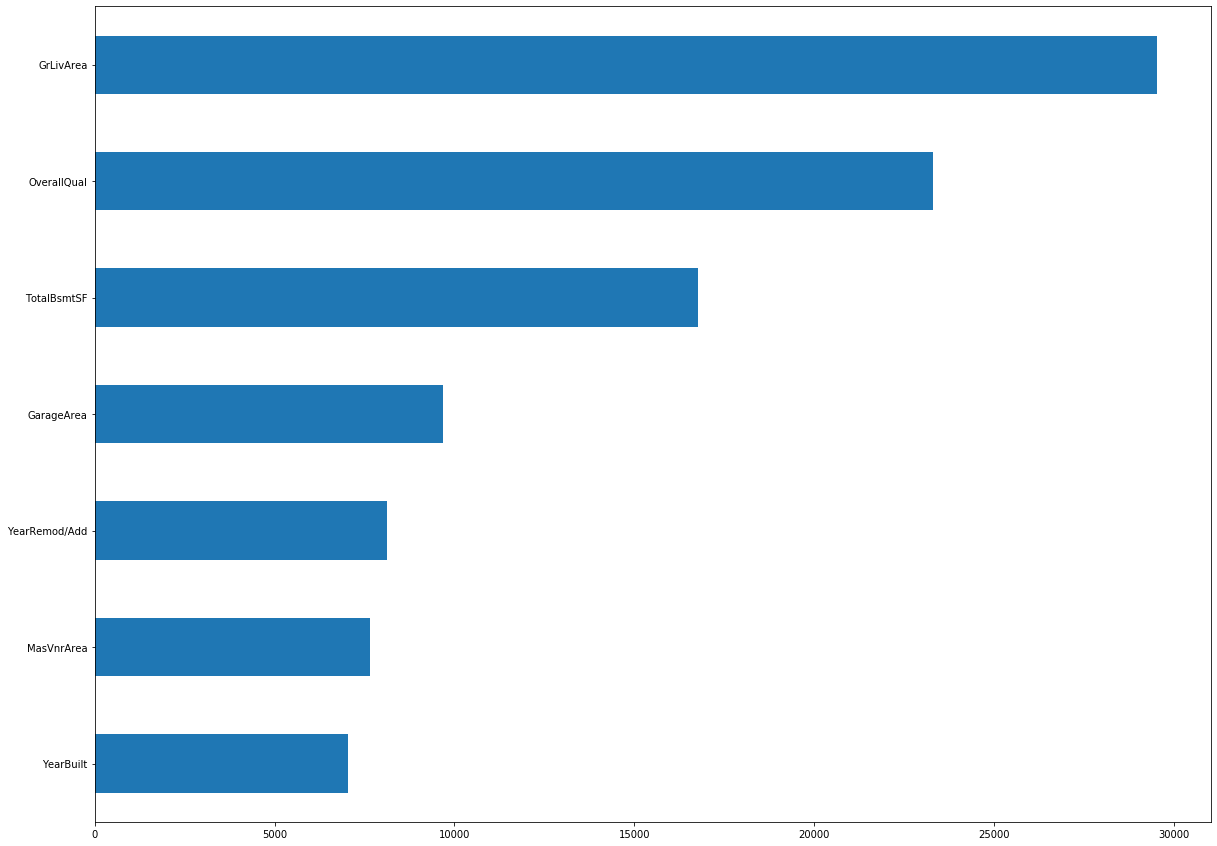

In [41]:
features1 = ['TotRmsAbvGrd','MasVnrArea','FullBath','YearRemod/Add','YearBuilt','GarageCars','GarageArea', 'TotalBsmtSF',
             'GrLivArea','OverallQual']
prediction1 = modeling(features1,train,test)

In [42]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction1})
df_pred.head()

,Id,SalePrice
0,2658,164275.628125
1,2718,218903.118335
2,2414,185463.151485
3,1989,127970.736122
4,625,191524.141361


In [43]:
df_pred.to_csv('result_50_numeric.csv', index=False)

#### Model 2

All numeric data with positive correlation with saleprice.

Model R2 Scores:
linear regression R2 score: 0.8607793056385076
ridge model R2 score: 0.8609994740189976
lasso net R2 score: 0.8613213063410173
elastic net R2 score: 0.8613213063410173
Model RMSE Scores:
linear regression RMSE score: 29469.030946111237
ridge model RMSE score: 29444.892282518605
lasso net RMSE score: 29409.479588161223
elastic net RMSE score: 29409.479588161223
Lowest RMSE is Lasso Model: 29409.479588161223
Lasso Coef count: 19


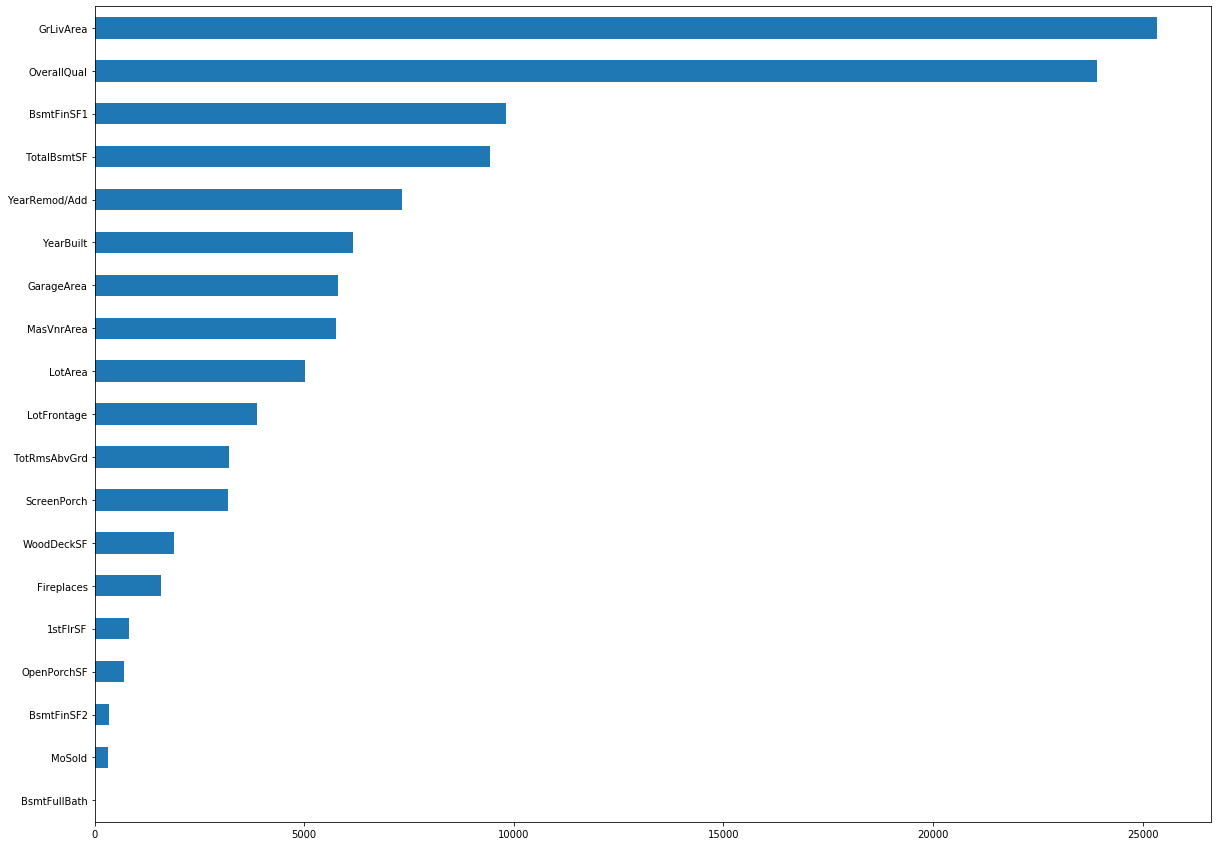

In [44]:
features2 = ['OverallQual','GrLivArea','TotalBsmtSF','GarageArea','1stFlrSF',
           'GarageCars','YearBuilt','YearRemod/Add','FullBath','MasVnrArea',
           'TotRmsAbvGrd','Fireplaces','BsmtFinSF1','LotFrontage','OpenPorchSF',
           'WoodDeckSF','LotArea','BsmtFullBath','HalfBath','2ndFlrSF', 'BsmtUnfSF',
           'BedroomAbvGr','ScreenPorch','3SsnPorch','MoSold','PoolArea','BsmtFinSF2']

prediction2 = modeling(features2,train,test)

In [45]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction2})
df_pred.head()

,Id,SalePrice
0,2658,152961.952656
1,2718,163569.000211
2,2414,202125.131291
3,1989,115440.244022
4,625,180300.143492


In [46]:
df_pred.to_csv('result_pos_numeric.csv', index=False)

#### Model 3

All numeric data

Since the first two model yielded good predictions I decided to try using all numeric data in the data set to predict sale price.

Model R2 Scores:
linear regression R2 score: 0.8642417676048758
ridge model R2 score: 0.864815668525796
lasso net R2 score: 0.8656673711433986
elastic net R2 score: 0.8656673711433986
Model RMSE Scores:
linear regression RMSE score: 29108.38455808576
ridge model RMSE score: 29045.47982664548
lasso net RMSE score: 28952.612835976568
elastic net RMSE score: 28952.612835976568
Lowest RMSE is Lasso Model: 28952.612835976568
Lasso Coef count: 21


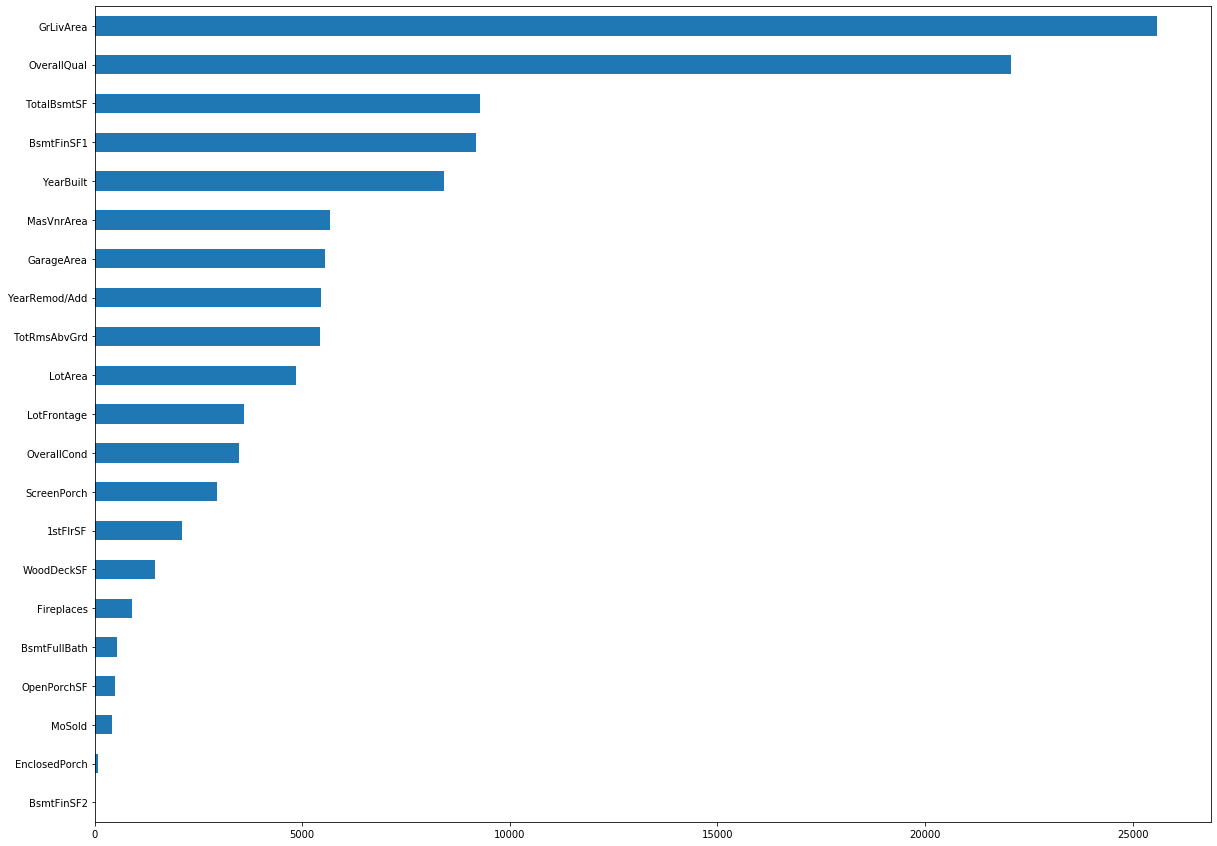

In [47]:
features3 = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                 'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

prediction3 = modeling(features3,train,test)

In [48]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction3})
df_pred.head()

,Id,SalePrice
0,2658,148034.948315
1,2718,153163.402430
2,2414,201567.873806
3,1989,112765.108178
4,625,178671.726052


In [49]:
df_pred.to_csv('result_all_numeric.csv', index=False)

#### Model 4

Modeling with dummy variables 

Since the numeric datas yield great predictions I decided to add some categorical data that show good correlation using a box plot in the EDA file.

In [50]:
train_dummy = pd.read_csv('datasets/train_dummy.csv')
test_dummy = pd.read_csv('datasets/test_dummy.csv')

In [51]:
train_dummy

,Unnamed: 0,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0,68.0,13517,6,8,1976,2005,289.0,533.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1,43.0,11492,7,5,1996,1997,132.0,637.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2,68.0,7922,5,7,1953,2007,0.0,731.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,3,73.0,9802,5,5,2006,2007,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,4,82.0,14235,6,8,1900,1993,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,2039,79.0,11449,8,5,2007,2007,0.0,1011.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2040,2040,68.0,12342,4,5,1940,1950,0.0,262.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2041,2041,57.0,7558,6,6,1928,1950,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2042,2042,80.0,10400,4,5,1956,1956,0.0,155.0,750.0,...,0,0,0,0,0,0,0,0,0,1


In [52]:
train_dummy = train_dummy.drop(['Unnamed: 0'],axis=1)

In [53]:
test_dummy

,Unnamed: 0,Id,PID,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD
0,0,2658,902301120,69.0,9142,6,8,1910,1950,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1,2718,905108090,0.0,9662,5,4,1977,1977,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2,2414,528218130,58.0,17104,7,5,2006,2006,0.0,...,0,0,0,0,0,0,1,0,0,0
3,3,1989,902207150,60.0,8520,5,6,1923,2006,0.0,...,0,0,0,0,0,0,0,0,0,1
4,4,625,535105100,0.0,9500,6,5,1963,1963,247.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,874,1662,527377110,80.0,8000,6,6,1974,1974,0.0,...,0,0,0,0,0,0,0,0,0,1
875,875,1234,535126140,90.0,14670,6,7,1966,1999,410.0,...,0,0,0,0,0,0,0,0,0,1
876,876,1373,904100040,55.0,8250,5,5,1968,1968,0.0,...,0,0,0,0,0,0,0,0,0,1
877,877,1672,527425140,60.0,9000,4,6,1971,1971,0.0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
test_dummy = test_dummy.drop(['Unnamed: 0'],axis=1)

In [55]:
print(train_dummy.shape)
print(test_dummy.shape)

(2044, 290)
(879, 301)


Model R2 Scores:
linear regression R2 score: -1.6698795675099594e+25
ridge model R2 score: 0.9151653897861882
lasso net R2 score: 0.9196211599151244
elastic net R2 score: 0.9196211599151244
Model RMSE Scores:
linear regression RMSE score: 2.0588063763128858e+17
ridge model RMSE score: 22989.448486604346
lasso net RMSE score: 22409.858306822047
elastic net RMSE score: 22409.858306822047
Lowest RMSE is Lasso Model: 22409.858306822047
Lasso Coef count: 78


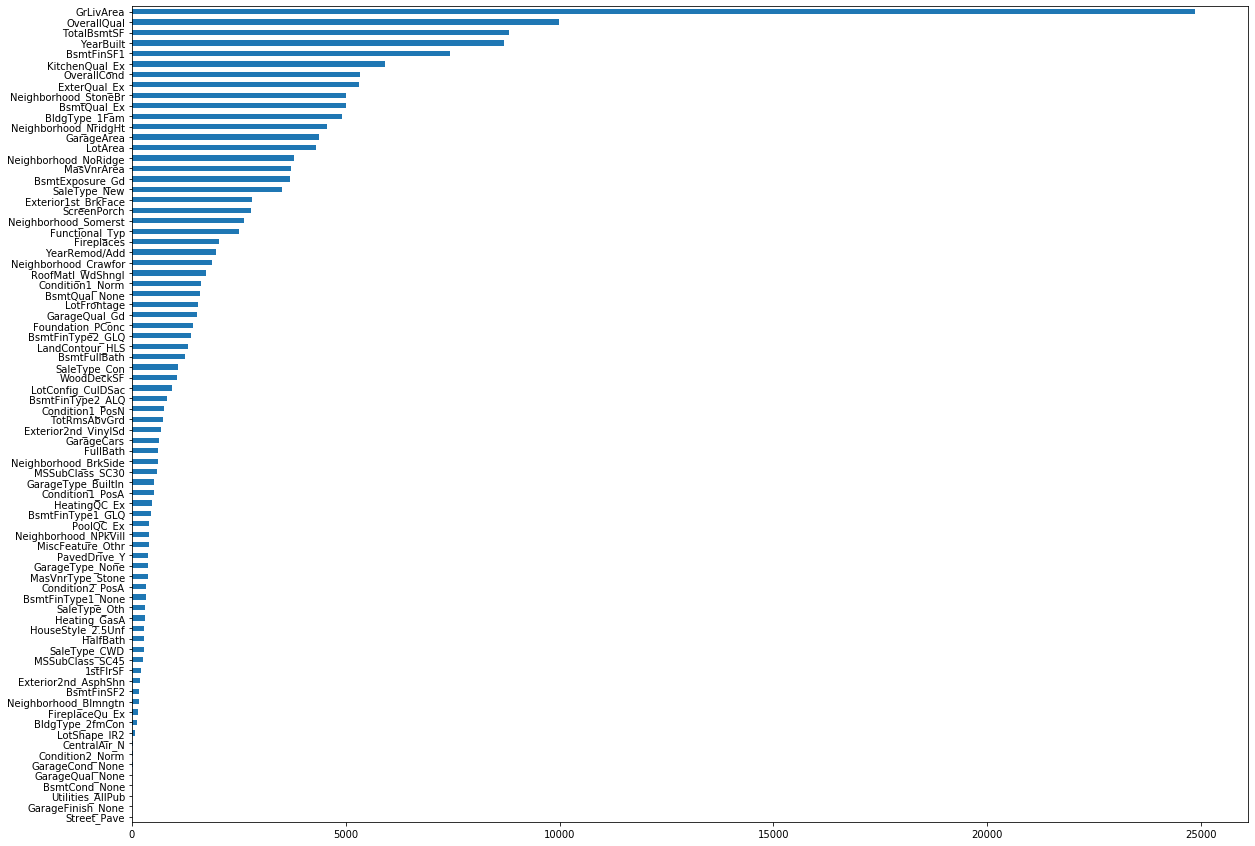

In [56]:
features4 = [col for col in train_dummy.columns if col != 'SalePrice']

prediction4 = modeling(features4,train_dummy,test_dummy)

In [57]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction4})
df_pred.head()

,Id,SalePrice
0,2658,139216.547451
1,2718,154855.330746
2,2414,210033.846455
3,1989,111311.911462
4,625,172848.911150


In [58]:
df_pred.to_csv('result_all_dummy.csv', index=False)

#### Model 5

Removing outliers using Z score in the train_dummy data

In [59]:
def detect_outlier(data_1):
    outliers=[]
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [60]:
print(detect_outlier(train.SalePrice))
#according to the Z Score calculation the list below are the outliers data in SalePrice

[465000, 501837, 545224, 556581, 457347, 430000, 460000, 441929, 421250, 446261, 451950, 552000, 468000, 500067, 538000, 455000, 450000, 475000, 426000, 466500, 475000, 555000, 438780, 500000, 440000, 535000, 445000, 611657, 584500, 485000, 582933, 591587, 425000]


In [61]:
def remove_outliers(outliers,df):
    for value in outliers:
        indexval = df[(df['SalePrice'] == value)].index
        df.drop(indexval, inplace=True)
    return df.shape

In [62]:
remove_outliers(detect_outlier(train.SalePrice),train_dummy)

(2011, 290)

In [63]:
train_dummy.to_csv('train_dummy_no_outliers.csv',index=False)

Model R2 Scores:
linear regression R2 score: -2.66860073840569e+25
ridge model R2 score: 0.9138213682387356
lasso net R2 score: 0.9188063333624941
elastic net R2 score: 0.9188063333624941
Model RMSE Scores:
linear regression RMSE score: 2.836963142672158e+17
ridge model RMSE score: 20142.232374818115
lasso net RMSE score: 19547.590383992323
elastic net RMSE score: 19547.590383992323
Lowest RMSE is Lasso Model: 19547.590383992323
Lasso Coef count: 81


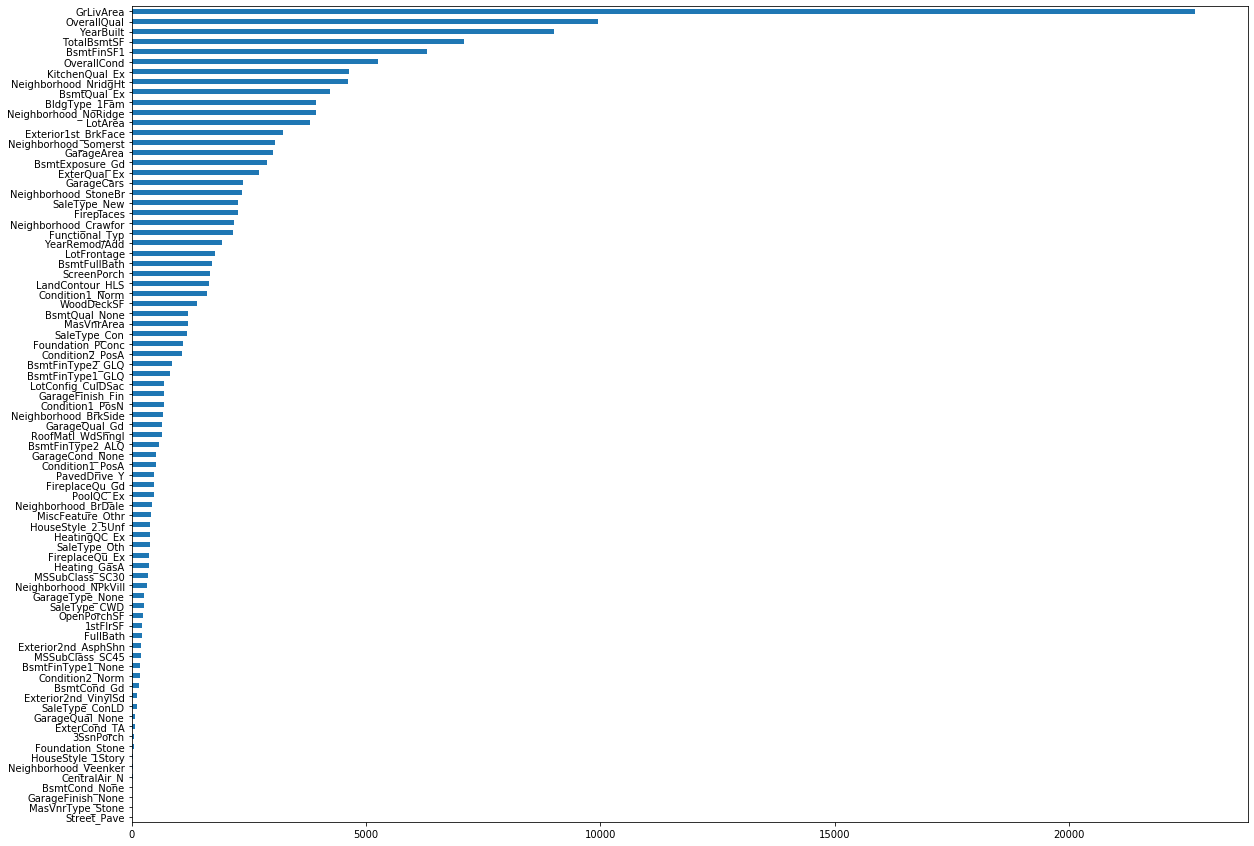

In [64]:
features5 = [col for col in train_dummy.columns if col != 'SalePrice']

prediction5 = modeling(features5,train_dummy,test_dummy)

In [65]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction5})
df_pred.head()

,Id,SalePrice
0,2658,136931.259914
1,2718,155233.488937
2,2414,210487.570830
3,1989,111488.637729
4,625,169681.788493


In [66]:
df_pred.to_csv('result_all_dummy_no_outliers.csv', index=False)

#### Model 6

Remove more outliers using IQR method

In [67]:
#identifying outliers in salesprice using IQR
q1, q3= np.percentile(train.SalePrice,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

In [68]:
print('Lower Bound',lower_bound)
print('Upper Bound',upper_bound)

Lower Bound 3718.75
Upper Bound 340168.75


In [69]:
train_IQRdummy = train_dummy[train_dummy['SalePrice'] >= 3718.75]
train_IQRdummy = train_dummy[train_dummy['SalePrice'] <= 340168.75]

In [70]:
train_IQRdummy.shape

(1950, 290)

Model R2 Scores:
linear regression R2 score: -4.447609359166881e+25
ridge model R2 score: 0.9036826708018924
lasso net R2 score: 0.9095068755544187
elastic net R2 score: 0.9095068755544187
Model RMSE Scores:
linear regression RMSE score: 3.130704195412525e+17
ridge model RMSE score: 18318.216725430426
lasso net RMSE score: 17750.37563833801
elastic net RMSE score: 17750.37563833801
Lowest RMSE is Lasso Model: 17750.37563833801
Lasso Coef count: 82


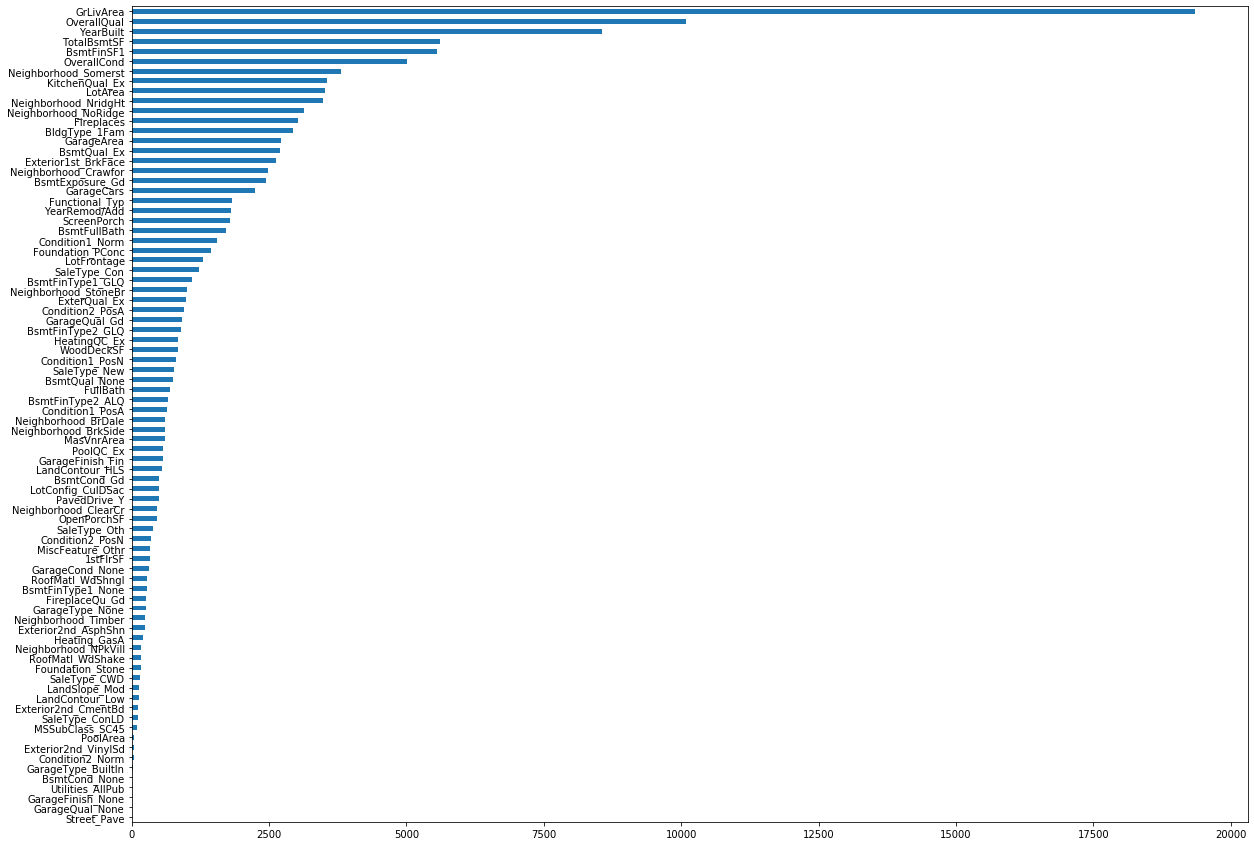

In [71]:
features6 = [col for col in train_IQRdummy.columns if col != 'SalePrice']

prediction6 = modeling(features6,train_IQRdummy,test_dummy)

In [72]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction6})
df_pred.head()

,Id,SalePrice
0,2658,136341.832661
1,2718,155116.621360
2,2414,209214.792388
3,1989,111028.786375
4,625,172580.661212


In [73]:
df_pred.to_csv('result_all_dummy_no_IQRoutliers.csv', index=False)
#removing this outliers cause the score in kaggle to go up.

#### Model 7

Picking top correlation features

In [74]:
corr = train_dummy.corr()
corr.sort_values(by='SalePrice',ascending=False).head(31)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
SalePrice,0.334848,0.275706,0.802427,-0.085665,0.597463,0.567973,0.434362,0.408326,0.006672,0.186470,...,-0.043084,-0.112335,0.010349,0.042328,-0.057701,-0.007335,-0.037697,0.315628,-0.031829,-0.166935
OverallQual,0.155267,0.070133,1.000000,-0.075805,0.601050,0.576451,0.378597,0.221406,-0.033391,0.271784,...,-0.050074,-0.094342,0.022650,0.022499,-0.074053,-0.002557,-0.031660,0.299262,-0.051257,-0.158348
GrLivArea,0.299156,0.260896,0.537951,-0.107309,0.242696,0.305120,0.304963,0.116495,-0.005738,0.233964,...,-0.031295,-0.041892,0.014269,-0.006124,-0.048759,0.008262,-0.023029,0.110197,-0.038512,-0.045217
GarageCars,0.273687,0.199266,0.567894,-0.163295,0.534087,0.427724,0.323501,0.237043,-0.003927,0.163426,...,-0.037596,-0.044206,-0.014699,0.014392,-0.037915,-0.006540,-0.023619,0.232978,-0.044795,-0.135455
GarageArea,0.311934,0.226409,0.534694,-0.130962,0.477285,0.382361,0.324637,0.275890,0.012831,0.142245,...,-0.029448,-0.021838,-0.027832,0.012442,-0.017778,-0.010598,-0.027776,0.235375,-0.051845,-0.149235
TotalBsmtSF,0.275168,0.224369,0.515756,-0.155223,0.406707,0.293681,0.322963,0.452181,0.097503,0.444970,...,-0.045734,0.000895,-0.001307,0.019087,-0.055031,0.017214,-0.042901,0.203167,-0.012443,-0.140387
1stFlrSF,0.383574,0.322778,0.445663,-0.149588,0.313747,0.222536,0.308081,0.377155,0.110768,0.320988,...,-0.000966,0.022096,0.021629,0.009056,-0.029984,0.005154,-0.055222,0.157986,-0.008410,-0.123471
YearBuilt,0.088626,0.016790,0.601050,-0.364629,1.000000,0.624418,0.299695,0.257777,-0.022078,0.132939,...,-0.050647,-0.081611,-0.027151,0.037499,-0.033315,-0.013186,-0.045246,0.323730,-0.025610,-0.186101
YearRemod/Add,0.065086,0.030300,0.576451,0.050002,0.624418,1.000000,0.173618,0.140154,-0.057871,0.155625,...,-0.028067,-0.158625,-0.033519,0.027405,-0.029776,-0.003971,-0.058617,0.303734,-0.047526,-0.124692
Foundation_PConc,0.047357,-0.038508,0.564724,-0.278149,0.660149,0.603428,0.174398,0.098601,-0.120009,0.224226,...,-0.071863,-0.143161,-0.020360,0.027585,-0.034806,-0.012084,-0.004328,0.301221,-0.017351,-0.143308


Model R2 Scores:
linear regression R2 score: 0.8876804482247754
ridge model R2 score: 0.8877654308830893
lasso net R2 score: 0.8877109239501154
elastic net R2 score: 0.8877109239501154
Model RMSE Scores:
linear regression RMSE score: 22982.778559743718
ridge model RMSE score: 22976.15777422962
lasso net RMSE score: 22980.058188348965
elastic net RMSE score: 22980.058188348965
Lowest RMSE is Ridge Model: 22976.15777422962
Ridge Coef count: 27


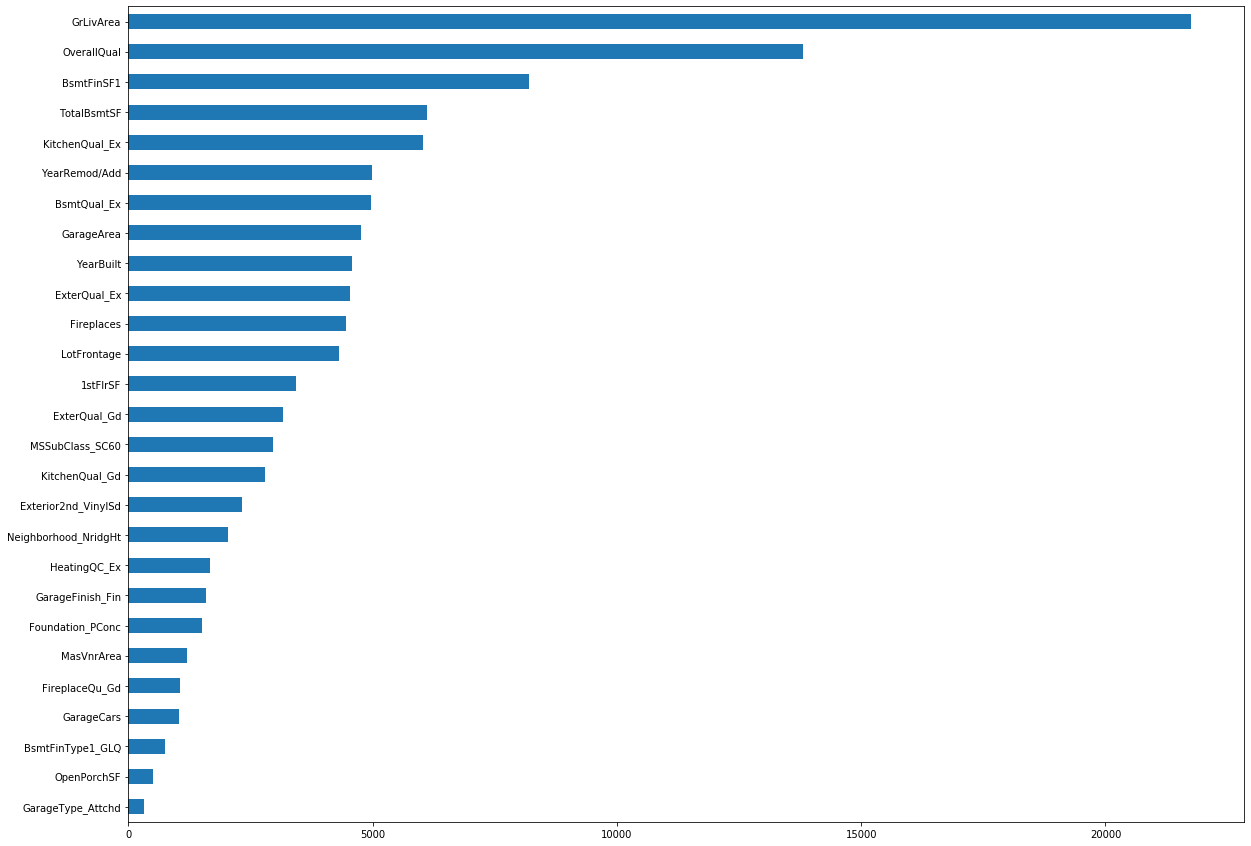

In [75]:
features7 = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','YearBuilt','YearRemod/Add','Foundation_PConc',
            'FullBath', 'ExterQual_Gd','BsmtQual_Ex','BsmtFinType1_GLQ','Fireplaces','KitchenQual_Ex','TotRmsAbvGrd','HeatingQC_Ex',
            'MasVnrArea','GarageFinish_Fin','Neighborhood_NridgHt','GarageType_Attchd','BsmtFinSF1','KitchenQual_Gd','ExterQual_Ex',
            'MSSubClass_SC60','FireplaceQu_Gd','Exterior1st_VinylSd','Exterior2nd_VinylSd','LotFrontage','OpenPorchSF']

prediction7 = modeling(features7,train_dummy,test_dummy)

In [76]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction7})
df_pred.head()

,Id,SalePrice
0,2658,139437.155731
1,2718,163782.303417
2,2414,201014.419154
3,1989,119037.173661
4,625,166162.779354


In [77]:
df_pred.to_csv('result_all_dummy_top30.csv', index=False)

#### Model 8

Picking correlation features with 0.5 or more.

Model R2 Scores:
linear regression R2 score: 0.8721789290687498
ridge model R2 score: 0.8721991129825696
lasso net R2 score: 0.8722335235254587
elastic net R2 score: 0.8722335235254587
Model RMSE Scores:
linear regression RMSE score: 24518.54654067936
ridge model RMSE score: 24518.72612127303
lasso net RMSE score: 24515.206150384827
elastic net RMSE score: 24515.206150384827
Lowest RMSE is Lasso Model: 24515.206150384827
Lasso Coef count: 14


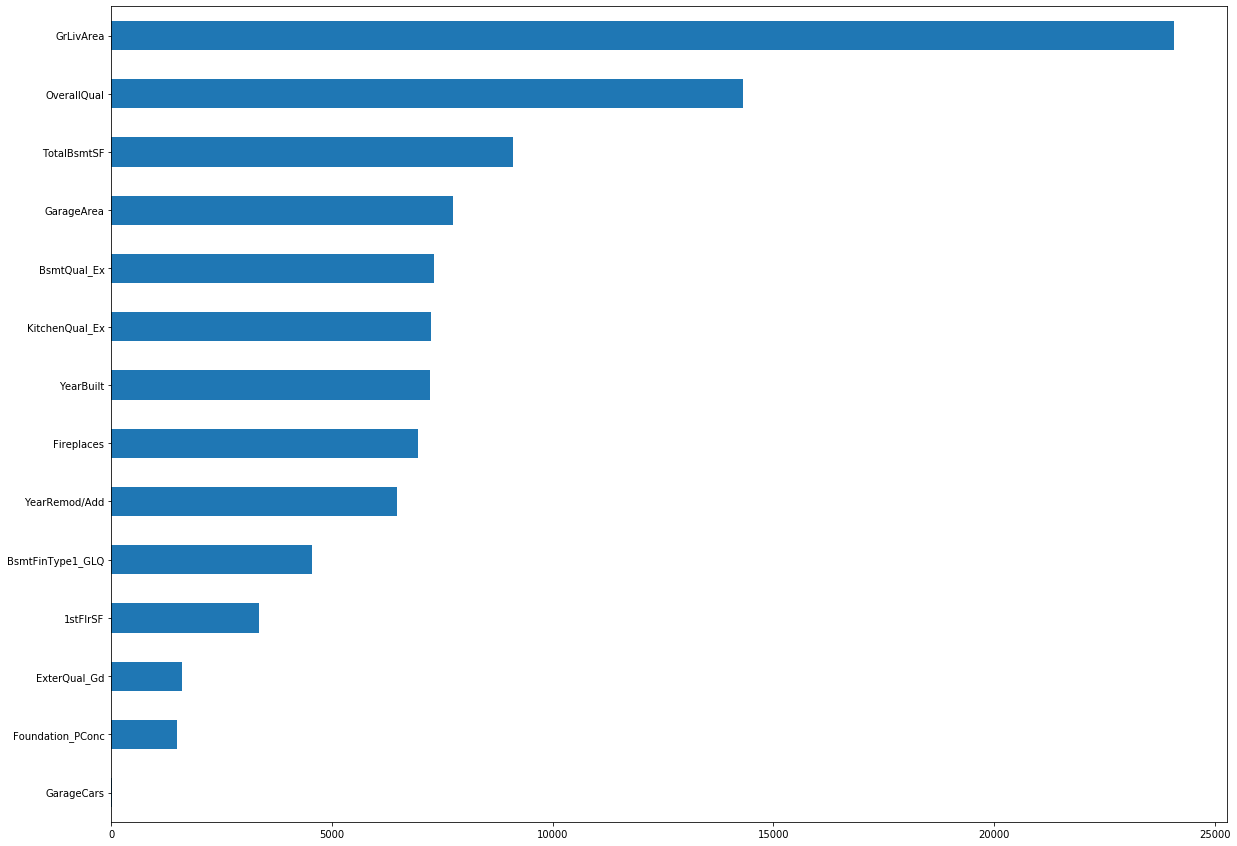

In [79]:
#trying feature with correlation above 0.5
features8 = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','YearBuilt','YearRemod/Add','Foundation_PConc',
            'FullBath', 'ExterQual_Gd','BsmtQual_Ex','BsmtFinType1_GLQ','Fireplaces','KitchenQual_Ex','TotRmsAbvGrd']
prediction8 = modeling(features8,train_dummy,test_dummy)

In [80]:
df_pred = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction8})
df_pred.head()

,Id,SalePrice
0,2658,146821.032057
1,2718,197162.101206
2,2414,195536.013757
3,1989,125466.809072
4,625,185956.687231


In [81]:
df_pred.to_csv('result_all_dummy_top0.5.csv', index=False)

---

## Final Model

Model 5 gave the best prediction results. We will now drive deeper into the model and tune differnt estimators to see which gives the best result.

- Testing different model
- Testing higher alpha to prevent overfitting
    - Using the best fit alpha overfit the predictions so we will try alpha at 2500

In [82]:
train_dummy = pd.read_csv('datasets/train_dummy_no_outliers.csv')

In [83]:
def modeling_2500(features,train,test):
    # picking features and normalizing the data
    Xtrain = train[features]
    y = train['SalePrice']
    ss = StandardScaler()
    Xtrain_ss = ss.fit_transform(Xtrain)
    Xtest = test[features] #test set
    Xtest_ss = ss.transform(Xtest) #test set
    
    # training and optimized each model
    lr = LinearRegression()
    
    ridgecv = RidgeCV(alphas=np.linspace(0.1,10,100))
    ridgecv.fit(Xtrain_ss,y)
    ridge = Ridge(alpha=2500)
    
    lassocv = LassoCV(n_alphas=100)
    lassocv.fit(Xtrain_ss,y)
    lasso = Lasso(alpha=2500)

    elasticnetcv = ElasticNetCV(n_alphas=100, l1_ratio=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    elasticnetcv.fit(Xtrain_ss,y)
    elasticnet = ElasticNet(alpha=2500, l1_ratio=(elasticnetcv.l1_ratio_))
    
    # calculating the R2 scores for each model after parameters optimization
    print('Model R2 Scores:')
    print('linear regression R2 score:', cross_val_score(lr,Xtrain_ss,y,cv=5).mean())
    print('ridge model R2 score:', cross_val_score(ridge,Xtrain_ss,y,cv=5).mean())
    print('lasso net R2 score:', cross_val_score(lasso,Xtrain_ss,y,cv=5).mean())
    print('elastic net R2 score:', cross_val_score(elasticnet,Xtrain_ss,y,cv=5).mean())
    
    # calculating the RMSE scores for each model after parameters optimization
    lr_rmse = np.abs(cross_val_score(lr,Xtrain_ss,y,cv=5, scoring='neg_root_mean_squared_error')).mean()
    ridge_rmse = np.abs(cross_val_score(ridge,Xtrain_ss,y,cv=5, scoring='neg_root_mean_squared_error')).mean()
    lasso_rmse = np.abs(cross_val_score(lasso,Xtrain_ss,y,cv=5, scoring='neg_root_mean_squared_error')).mean()
    eln_rmse = np.abs(cross_val_score(elasticnet,Xtrain_ss,y,cv=5, scoring='neg_root_mean_squared_error')).mean()
    print('Model RMSE Scores:')
    print('linear regression RMSE score:', lr_rmse)
    print('ridge model RMSE score:', ridge_rmse)
    print('lasso net RMSE score:', lasso_rmse)
    print('elastic net RMSE score:', eln_rmse)

    if lr_rmse <= ridge_rmse and lr_rmse <= lasso_rmse and lr_rmse <= eln_rmse:
        print('Lowest RMSE is Linear Regression Model:', lr_rmse)
        lr.fit(Xtrain_ss,y)
        prediction = lr.predict(Xtest_ss)
        coef_all = pd.Series(lr.coef_,index=features).sort_values(ascending=True, inplace=False)
        coef = pd.Series(coef_all[coef_all>0])
        print('Linear Regression Coef count:', coef_all[coef_all>0].count())
        plt.figure(figsize = (20,15))
        coef.plot.barh()
        plt.show()
    elif ridge_rmse <= lr_rmse and ridge_rmse <= lasso_rmse and ridge_rmse <= eln_rmse:
        print('Lowest RMSE is Ridge Model:', ridge_rmse)
        ridge.fit(Xtrain_ss,y)
        prediction = ridge.predict(Xtest_ss)
        coef_all = pd.Series(ridge.coef_,index=features).sort_values(ascending=True, inplace=False)
        coef = pd.Series(coef_all[coef_all>0])
        print('Ridge Coef count:', coef_all[coef_all>0].count())
        plt.figure(figsize = (20,15))
        coef.plot.barh()
        plt.show()
    elif lasso_rmse <= lr_rmse and lasso_rmse <= ridge_rmse and lasso_rmse <= eln_rmse:
        print('Lowest RMSE is Lasso Model:', lasso_rmse)
        lasso.fit(Xtrain_ss,y)
        prediction = lasso.predict(Xtest_ss)
        coef_all = pd.Series(lasso.coef_,index=features).sort_values(ascending=True, inplace=False)
        coef = pd.Series(coef_all[coef_all>0])
        print('Lasso Coef count:', coef_all[coef_all>0].count())
        plt.figure(figsize = (20,15))
        coef.plot.barh()
        plt.show()
    else:
        print('Lowest RMSE is Elasticnet Model:', eln_rmse)
        elasticnet.fit(Xtrain_ss,y)
        prediction = elasticnet.predict(Xtest_ss)
        coef_all = pd.Series(elasticnet.coef_,index=features).sort_values(ascending=True, inplace=False)
        coef = pd.Series(coef_all[coef_all>0])
        print('Elastic Net Coef count:', coef_all[coef_all>0].count())
        plt.figure(figsize = (20,15))
        coef.plot.barh()
        plt.show()
    return prediction

Model R2 Scores:
linear regression R2 score: -2.66860073840569e+25
ridge model R2 score: 0.8852398578979704
lasso net R2 score: 0.8966446802783107
elastic net R2 score: 0.8966446802783107
Model RMSE Scores:
linear regression RMSE score: 2.836963142672158e+17
ridge model RMSE score: 23280.8458255465
lasso net RMSE score: 22052.719932697724
elastic net RMSE score: 22052.719932697724
Lowest RMSE is Lasso Model: 22052.719932697724
Lasso Coef count: 34


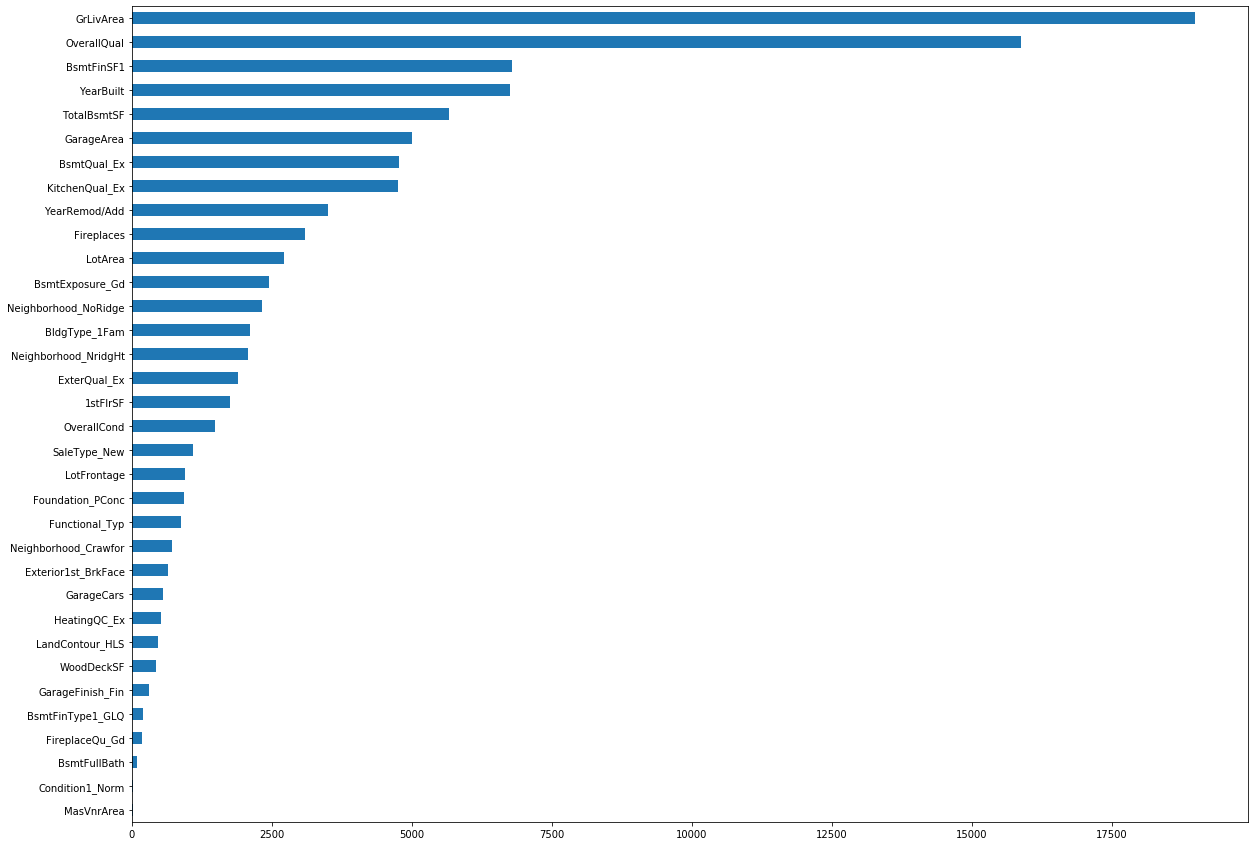

In [84]:
model5_feature = [col for col in train_dummy.columns if col != 'SalePrice']

model5_pred = modeling_2500(model5_feature,train_dummy,test_dummy)

In [85]:
df_pred = pd.DataFrame({'Id':test_dummy['Id'], 'SalePrice':model5_pred})
df_pred.head()

,Id,SalePrice
0,2658,150381.635640
1,2718,173372.439154
2,2414,205825.719445
3,1989,118095.004118
4,625,171834.555664


In [86]:
df_pred.to_csv('result_final_lasso.csv', index=False)